`Copyright (c) Meta Platforms, Inc. and affiliates. This source code is licensed under the CC-BY-NC license found in the LICENSE file in the root directory of this source tree.`

## This notebook downloads and analyzes EIA's bulk U.S. Electric System Operating Data 
For description of the data, see: https://www.eia.gov/opendata/bulkfiles.php


In [1]:
from src.download_and_process import *
import os

# SET the data path (<EIA_bulk_data_dir>) for location of EIA data
EIA_bulk_data_dir = os.getcwd() + "/EBA"


In [ ]:
# Download EIA's U.S. Electric System Operating Data
# SKIP this step, if EIA data is already downloaded

downloadAndExtract(EIA_bulk_data_dir)

In [2]:
# CONSTANTS
# Energy types in the grid
ng_list = [
    "WND", # wind
    "SUN", # solar
    "WAT", # hydro
    "OIL", # oil
    "NG",  # natural gas
    "COL", # coal
    "NUC", # nuclear
    "OTH", # other
]

# Renewable energy types
rn_list = ["WND", "SUN", "WAT"]

# Carbon intensity of the energy types, gCO2eq/kWh
carbon_intensity = {
    "WND": 11,
    "SUN": 41,
    "WAT": 24,
    "OIL": 650,
    "NG":  490,
    "COL": 820,
    "NUC": 12,
    "OTH": 230,
}


## Prepare EIA energy source data for processing

### **`prepareEIAData():`** Reads the EIA bulk json file and converts it into a data frame.

Populates `ba_list`, which is a list of all balancing authorities in the US.

Populates `eba_json`, which will be used later for `extractBARange` function.

In [3]:
eba_json, ba_list, ta_list = prepareEIAData(EIA_bulk_data_dir)

print("List of all balancing authorities: \t", ba_list)

EIA data prep done!
List of all balancing authorities: 	 ['CAR', 'DUK', 'EPE', 'FLA', 'FPC', 'FPL', 'WAUW', 'SRP', 'FMPP', 'PACW', 'PSCO', 'PSEI', 'SCEG', 'SOCO', 'AZPS', 'BANC', 'BPAT', 'CHPD', 'NY', 'TEN', 'TEX', 'SWPP', 'TEPC', 'TIDC', 'TPWR', 'US48', 'WACM', 'WALC', 'CENT', 'NW', 'SC', 'SE', 'SW', 'AVA', 'CAL', 'CISO', 'CPLE', 'CPLW', 'DOPD', 'ERCO', 'GCPD', 'IPCO', 'GVL', 'HST', 'NYIS', 'PACE', 'PGE', 'PJM', 'PNM', 'SCL', 'SEC', 'SPA', 'TAL', 'TEC', 'TVA', 'AECI', 'LDWP', 'MIDW', 'NE', 'NWMT', 'JEA', 'ISNE', 'MISO', 'NEVP', 'LGEE', 'MIDA', 'IID', 'GWA', 'SEPA', 'GRID', 'GRIF', 'HGMA', 'DEAA', 'WWA', 'YAD', 'AVRN', 'GLHB', 'AEC', 'EEI', 'NSB', 'OVEC', 'GRMA']


## Retrieving a dataframe of energy generation for a BA
### **`extractBARange(ba_idx, start_day, end_day):`**

`ba_idx`: id of the balancing authority, i.e. CISO

`start_day`: starting date of the time frame, i.e. "2021-01-01"

`end_day`: ending date of the time frame, i.e. "2021-01-01"

The returning dataframe will be date indexed with UTC time zone.


In [4]:
START_DATE = "2021-01-01"
END_DATE = "2021-08-01"

# Example: extract the energy generation values of a particular BA
# between START_DATE and END_DATE
ba_idx = ba_list[0]
db = extractBARange(ba_idx, START_DATE, END_DATE)

In [5]:
db

,WND,SUN,WAT,OIL,NG,COL,NUC,OTH
2021-01-01 00:00:00+00:00,0,26,1052,0,5977,3932,12042,1376
2021-01-01 01:00:00+00:00,0,28,1061,0,5674,3543,12046,1276
2021-01-01 02:00:00+00:00,0,-3,958,-1,5671,2827,12038,1193
2021-01-01 03:00:00+00:00,0,-3,896,0,5278,2650,12046,1073
2021-01-01 04:00:00+00:00,0,-1,863,0,4785,2621,12047,986
...,...,...,...,...,...,...,...,...
2021-07-31 20:00:00+00:00,0,2839,2710,0,9984,9817,11095,1121
2021-07-31 21:00:00+00:00,0,2392,2774,0,10597,9791,11223,1126
2021-07-31 22:00:00+00:00,0,1774,2868,0,11035,9762,11330,1123
2021-07-31 23:00:00+00:00,0,996,2733,0,10939,9806,11428,1123


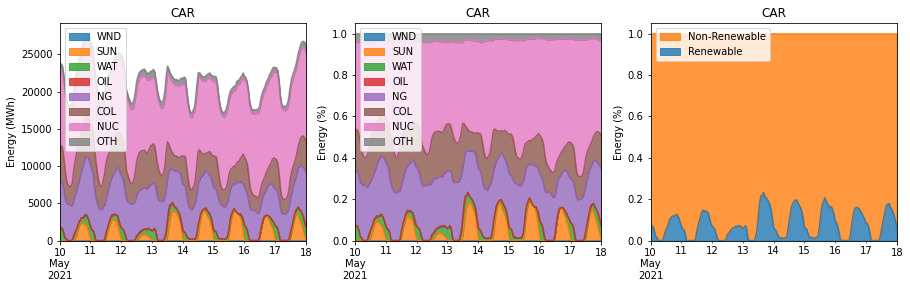

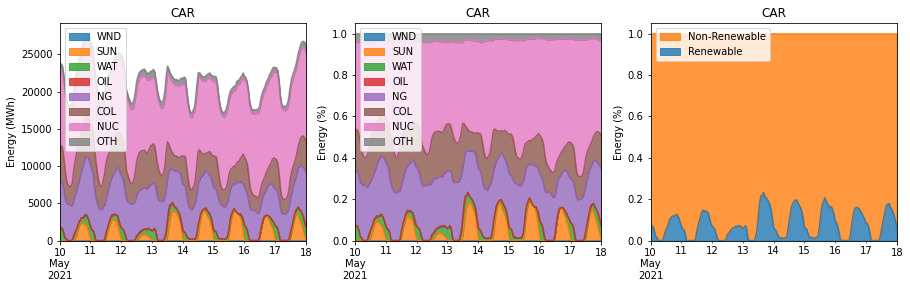

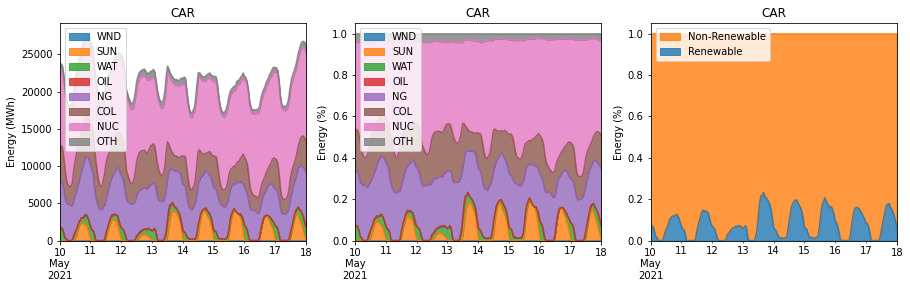

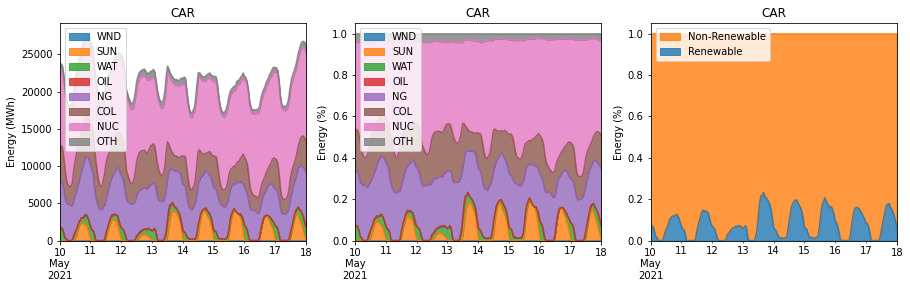

In [6]:
from functools import reduce
import matplotlib.pylab as plt

# Plot power source
START_DATE = '2021-05-10'
END_DATE = '2021-05-18'
    
# plot grid energy mix of all balancing authorities
#for ba_idx in ba_list:
# plot grid energy mix of selected balancing authorities
for ba in ['US48', 'CISO', 'CAR', 'BPAT']:
    db = extractBARange(ba, START_DATE, END_DATE)
    if(ba_idx != '-'):
        db = extractBARange(ba_idx, START_DATE, END_DATE)
        db[db < 0] = 0
        db = db.resample('H').sum() # Hourly(H) / Daily (D) / Monthly(M) sampling
        db_perc = db.divide(db.sum(axis=1), axis=0)
        db_all = db_perc.sum(axis=1)
        db_cf = db_perc[rn_list].sum(axis=1)
        db_ncf = db_all-db_cf
        result = pd.concat([db_cf, db_ncf], axis=1)
        
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
        ax = db.plot(ax=axes[0], kind='area', stacked=True, title=ba_idx, alpha=0.8)
        ax = db_perc.plot(ax=axes[1], kind='area', stacked=True, title=ba_idx, alpha=0.8)
        ax = result.plot(ax=axes[2], kind='area', stacked=True, title=ba_idx, alpha=0.8)
        axes[0].legend(loc='upper left')
        axes[1].legend(loc='upper left')
        axes[2].legend(reversed(plt.legend().legendHandles), ['Non-Renewable', 'Renewable'], loc='upper left')
        axes[0].set_ylabel("Energy (MWh)")
        axes[1].set_ylabel("Energy (%)")
        axes[2].set_ylabel("Energy (%)")
        plt.show()

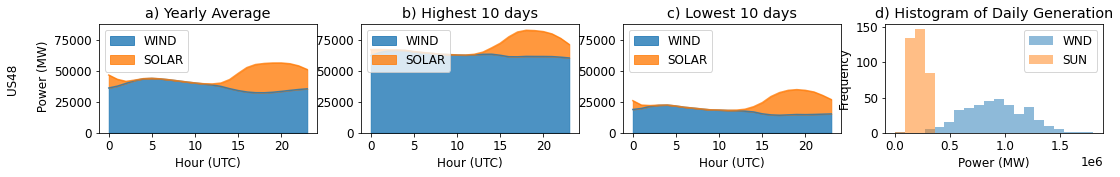

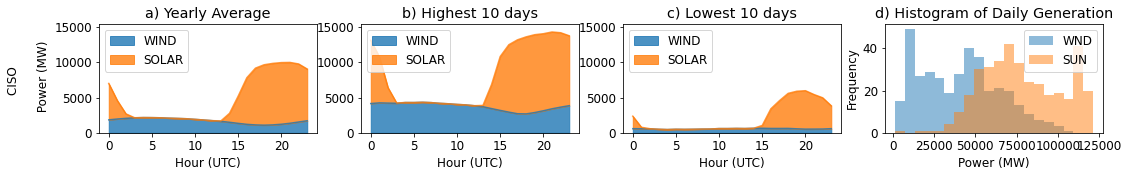

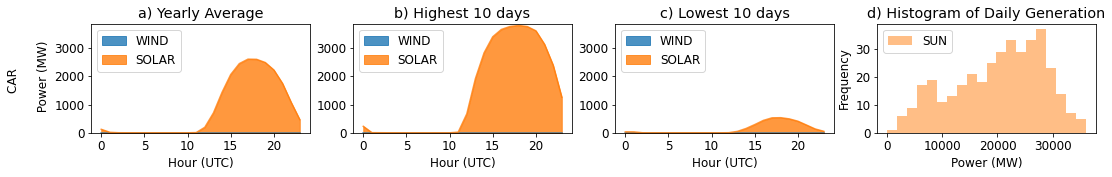

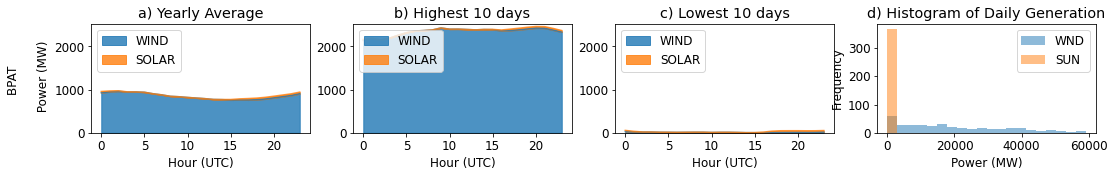

In [10]:
# Analyze yearly wind and solar energy generation distribution
# Generate four plots: daily average generation, highest 10 days, lowest 10 days, and histogram of daily generation

from datetime import date, datetime, timedelta, timezone

YEAR_START = "2020-01-01"
YEAR_END = "2021-01-01"

plt.rcParams.update({"font.size": 12})

# plot all balancing authorities
#for ba_idx in ba_list:
# plot selected balancing authorities
for ba_idx in ['US48', 'CISO', 'CAR', 'BPAT']:
    if ba_idx != "-":
        db = extractBARange(ba_idx, YEAR_START, YEAR_END)
        db[db < 0] = 0
        db = db.resample("H").sum()  # Hourly(H) / Daily (D) / Monthly(M) sampling

        # calculate highest and lowest 10 days of renewables
        # daily sum of wind and solar
        db_daily = db[["WND", "SUN"]].resample("D").sum()
        db_daily_hist = db_daily.reset_index(drop=True)
        if (db_daily_hist["WND"] == 0).all() == True:
            db_daily_hist.drop("WND", axis=1, inplace=True)
        if (db_daily_hist["SUN"] == 0).all() == True:
            db_daily_hist.drop("SUN", axis=1, inplace=True)
        # print(db_daily_hist.min())
        # print((db_daily_hist['WND'] == 0).sum())
        if db_daily_hist.empty:
            print("Balancing authority, ", ba_idx, ', does not have wind or solar energy!')
            continue
    
        db_ren = db_daily.sum(axis=1)

        # largest n days
        db_10_largest_days = db_ren.nlargest(10).index
        df_highest = []
        for i in db_10_largest_days:
            dbi = extractBARange(
                ba_idx,
                i.strftime("%Y-%m-%d"),
                (i + timedelta(days=1)).strftime("%Y-%m-%d"),
            )[:-1]
            dbi[dbi < 0] = 0
            df_highest.append(dbi)
        df_highest = pd.concat(df_highest)

        # print(db_10_lowest_days)
        df_all_highest = []
        # calculate hourly average of the lowest
        for h in range(0, 24, 1):
            d = df_highest.iloc[h::24, :].mean(axis=0)
            df_all_highest.append(d)
        df_all_highest = pd.concat(df_all_highest)
        dwnd = df_all_highest["WND"].to_frame("WIND").reset_index()
        dwnd = dwnd.drop(["index"], axis=1)
        dsol = df_all_highest["SUN"].to_frame("SOLAR").reset_index()
        dsol = dsol.drop(["index"], axis=1)
        df_hourly_highest = pd.concat(
            [dwnd, dsol],
            axis=1,
        )

        # lowest 10 days
        db_10_lowest_days = db_ren.nsmallest(10).index
        df_lowest = []
        for i in db_10_lowest_days:
            dbi = extractBARange(
                ba_idx,
                i.strftime("%Y-%m-%d"),
                (i + timedelta(days=1)).strftime("%Y-%m-%d"),
            )[:-1]
            dbi[dbi < 0] = 0
            df_lowest.append(dbi)
        df_lowest = pd.concat(df_lowest)

        df_all_lowest = []
        # calculate hourly average of the lowest
        for h in range(0, 24, 1):
            d = df_lowest.iloc[h::24, :].mean(axis=0)
            df_all_lowest.append(d)
        df_all_lowest = pd.concat(df_all_lowest)
        dwnd = df_all_lowest["WND"].to_frame("WIND").reset_index()
        dwnd = dwnd.drop(["index"], axis=1)
        dsol = df_all_lowest["SUN"].to_frame("SOLAR").reset_index()
        dsol = dsol.drop(["index"], axis=1)
        df_hourly_lowest = pd.concat(
            [dwnd, dsol],
            axis=1,
        )

        # average of all days
        df_all = []
        # calculate hourly average
        for h in range(0, 24, 1):
            d = db.iloc[h::24, :].mean(axis=0)
            df_all.append(d)
        df_all = pd.concat(df_all)
        dwnd = df_all["WND"].to_frame("WIND").reset_index()
        dwnd = dwnd.drop(["index"], axis=1)
        dsol = df_all["SUN"].to_frame("SOLAR").reset_index()
        dsol = dsol.drop(["index"], axis=1)
        df_hourly = pd.concat(
            [dwnd, dsol],
            axis=1,
        )

        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 2))
        ylim = df_hourly_highest["SOLAR"].max() + df_hourly_highest["WIND"].max() + 50
        for i in range(0, 3):
            if i == 0:
                d = df_hourly
                title = "a) Yearly Average"
            elif i == 1:
                d = df_hourly_highest
                title = "b) Highest 10 days"
            elif i == 2:
                d = df_hourly_lowest
                title = "c) Lowest 10 days"
            axes[i].set_xlabel("Hour (UTC)")
            ax = d.plot(ax=axes[i], kind="area", stacked=True, title=title, alpha=0.8)
            axes[i].legend(loc="upper left")
            axes[i].set_ylim(0, ylim)
        title4 = "d) Histogram of Daily Generation"
        axes[3].set_xlabel("Power (MW)")
        color_dict = {"WND": "#1f77b4", "SUN": "#ff7f0e"}
        db_daily_hist.plot.hist(
            bins=20,
            alpha=0.5,
            ax=axes[3],
            title=title4,
            color=[color_dict.get(x, "#333333") for x in db_daily_hist.columns],
        )
        axes[0].set_ylabel(ba_idx + " \n\n Power (MW)")
        plt.show()

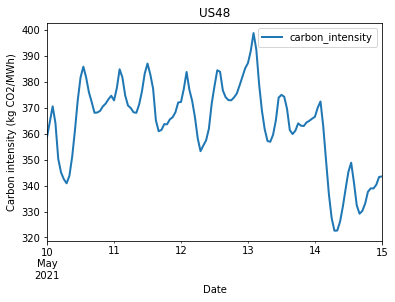

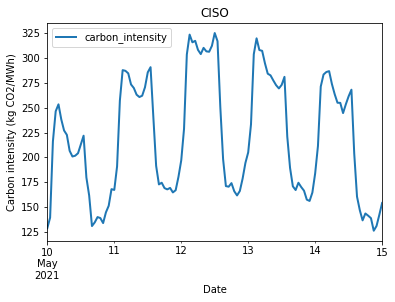

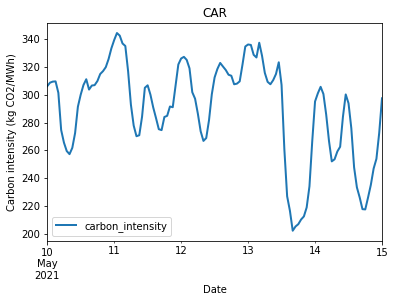

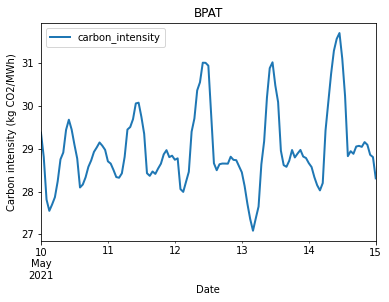

In [7]:
from src.download_and_process import *

START_DATE = '2021-05-10'
END_DATE = '2021-05-15'

# Plot carbon intensity of the grids

# plot grid energy mix of all balancing authorities
#for ba_idx in ba_list:
# plot grid energy mix of selected balancing authorities
for ba_idx in ['US48', 'CISO', 'CAR', 'BPAT']:
    db = extractBARange(ba_idx, START_DATE, END_DATE)
    carbon_intensity = calculateAVGCarbonIntensity(db)
    ax = carbon_intensity.plot(kind='line', stacked=False, title=ba_idx, lw=2)

    ax.set_xlabel("Date")
    ax.set_ylabel('Carbon intensity (kg CO2/MWh)')
    plt.show()
